<a href="https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/fit_mulltiple_1d_gaussians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides an example of how to fit multiple 1-d gaussians simultaneously in python as may be done in spec_fit. Code based on discussion at https://stackoverflow.com/questions/34136737/using-scipy-curve-fit-for-a-variable-number-of-parameters

Author: dmehring 12jan2022

Install casatools

In [307]:
import os
print("installing casatools (takes a minute)...")
os.system("apt-get install libgfortran3")
os.system("pip install casatools==6.3.0.48")
os.system('pip install casadata')
print('complete')

installing casatools (takes a minute)...
complete


imports

In [308]:
from casatools import functional
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

Define functions to determine rms and compute model values

In [309]:
def __rms(z: np.array) -> float:
  return np.sqrt(np.sum(z*z)/len(z))

def __model(x: np.array, g1d: list) -> np.array:
  model: np.array = np.zeros(len(x))
  for g in g1d:
    model += g.f(x)
  return model

Define chi square for curve fitting

In [310]:
def __chi_square(residual: np.array, sigma: float) -> float:
  residual_sigma = (residual)/sigma
  return np.sum(residual_sigma*residual_sigma)

Compute and return rms and chi-square

In [311]:
def __rms_chisquare(residual: np.array, sigma: float) -> tuple:
  return __rms(residual), __chi_square(residual, sigma)

Define function to plot data

In [312]:
# plot the data
def __plot(
    x: np.array, y: np.array, residual: np.array, x_smooth: np.array,
    model_smooth: np.array, fit: bool=False
  ) -> None:
  plt.plot(x, y, linestyle='', marker='o', markerfacecolor='red')
  plt.plot(x, residual, linestyle='', marker='x', markerfacecolor='#50C878')
  plt.plot(x_smooth, model_smooth, color='blue')
  plt.xlabel('V_LSR (km/s)')
  plt.ylabel('Intensity (Jy/beam')
  if fit:
    plt.title('Model Spectrum with Fit')
  else:
    plt.title('Model Spectrum')
  plt.show()


Create model.

In [313]:
def __create_model(amplitude: list, center: list, fwhm: list) -> tuple:
  fn = functional()
  g1d: list = []
  for a, c, f in zip(amplitude, center, fwhm):
    g1d.append(fn.gaussian1d(a, c, f))
  return g1d, len(g1d)

Define wrapper function that is used to fit multiple gaussians
N = number of gaussians to fit

In [314]:
def wrapper_fit_func(x, N, *args):
  amp, center, fwhm = args[:N], args[N:2*N], args[2*N:3*N]
  g1d = []
  fn = functional()
  for a, c, f in zip(amp, center, fwhm):
    g1d.append(fn.gaussian1d(a, c, f))
  return __model(x, g1d)

Create data

In [315]:
def __create_data(npixels: int, noise: float, g1d: list) -> tuple:
  residual: np.array = np.random.normal(0, noise, npixels)
  x: np.array = np.linspace(0, npixels, npixels, endpoint=False)
  model: np.array = __model(x, g1d)
  y: np.array = model + residual
  x_smooth: np.array = np.linspace(0, npixels, 100)
  model_smooth: np.array = __model(x_smooth, g1d)
  return x, y, model, residual, x_smooth, model_smooth

This function does the fit

In [316]:
def __fit(x: np.array, y: np.array, ngauss: int, params_0: list) -> list:
  try:
    popt, pcov = curve_fit(
        lambda x, *params_0:
          wrapper_fit_func(x, ngauss, *params_0), x, y, p0=params_0
      )
    perr: np.array = np.sqrt(np.diag(pcov))
    return popt, perr
  except RuntimeError as e:
    raise RuntimeError(f'Fit did not converge {e}')

Function to report the fit

In [317]:
def __report(
    popt: np.array, perr: np.array, y: np.array, noise: float, rms_orig: float,
    chi2_orig: float, ndigits: int
  ) -> np.array:
  popt = popt.round(ndigits)
  perr = perr.round(ndigits)
  amp_fit = popt[0:ngauss]
  center_fit = popt[ngauss:2*ngauss]
  fwhm_fit = popt[2*ngauss:3*ngauss]
  amp_err = perr[0:ngauss]
  center_err = perr[ngauss:2*ngauss]
  fwhm_err = perr[2*ngauss:3*ngauss]
  g1d_fit: list = []
  fn = functional()
  for i, (af, cf, ff, ae, ce, fe) in enumerate(
    zip(amp_fit, center_fit, fwhm_fit, amp_err, center_err, fwhm_err)
  ):
    print(f'Solution for gaussian {i}:')
    print(f'  Amplitude: {af} +/- {ae}')
    print(f'  Center: {cf} +/- {ce}')
    print(f'  FWHM: {ff} +/- {fe}')
    print()
    g1d_fit.append(fn.gaussian1d(af, cf, ff))
  model = __model(x, g1d_fit)
  rms_fit, chi2_fit = __rms_chisquare(y - model, noise)
  print(f'rms of residuals of fit: {round(rms_fit, ndigits)}')
  print(
    'Fit residuals have an rms that is ',
    f'{round(100*rms_fit/rms_orig, ndigits)}%',
    'of the rms of the original residuals'
  )
  print()
  print(f'chi-square of fit: {round(chi2_fit, ndigits)}')

  print(
    f'Chi-square of fit is {round(100*chi2_fit/chi2_orig, ndigits)}% '
    'chi-square of original'
  )
  return model

# TWO GAUSSIANS

In [318]:
# create a model with 2 gaussians
# first, create an array of 2 1-d gaussian functionals
g1d, ngauss = __create_model(amplitude=[5, 3], center=[10, 4], fwhm=[4, 6])
# now create some data with noise
noise = 0.2
npixels = 20
x, y, model, residual, x_smooth, model_smooth = __create_data(npixels, noise, g1d)

Compute and report the rms of the residuals

In [319]:
rms_orig, chi2_orig = __rms_chisquare(y-model, noise)
print(f'rms of residuals: {round(rms_orig, 3)}')
print(f'chi2: {round(chi2_orig, 3)}')

rms of residuals: 0.145
chi2: 10.541


Plot the data with the model overlaid

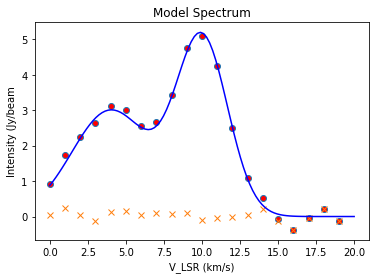

In [320]:
__plot(x, y, residual, x_smooth, model_smooth)

Perform the fit of two 1-d gaussians to the data

In [321]:
# params_0 are the initial guesses for the parameters, which would normally
# be provided by the user
# they are in the order [amp0, amp1, ..., ampN, center0, center1, ..., centerN,
# fwhm0, fwhm1, ..., fwhmN]
params_0 = [4.5, 2, 9, 5, 5, 7]
popt, perr = __fit(x, y, ngauss, params_0)

Summarize the fit

In [322]:
model_fit = __report(popt, perr, y, noise, rms_orig, chi2_orig, 3)

Solution for gaussian 0:
  Amplitude: 4.902 +/- 0.149
  Center: 10.005 +/- 0.081
  FWHM: 4.053 +/- 0.162

Solution for gaussian 1:
  Amplitude: 3.028 +/- 0.095
  Center: 4.009 +/- 0.173
  FWHM: 6.288 +/- 0.47

rms of residuals of fit: 0.131
Fit residuals have an rms that is  90.34% of the rms of the original residuals

chi-square of fit: 8.603
Chi-square of fit is 81.612% chi-square of original


Plot the data with the best fit model overlaid

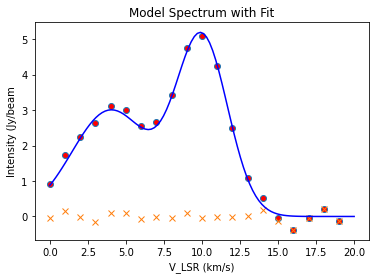

In [323]:
model_fit_smooth = __model(x_smooth, g1d)
__plot(x, y, y - model_fit, x_smooth, model_fit_smooth, True)        

# FOUR GAUSSIANS

In [324]:
# create a model with 4 gaussians
# first, create an array of 4 1-d gaussian functionals
g1d, ngauss = __create_model(
    amplitude=[5, 3, 10, 7], center=[10, 4, 15, 20], fwhm=[4, 6, 6, 3]
  )
npixels = 40
noise = 0.2
# then create data with noise
x, y, model, residual, x_smooth, model_smooth = __create_data(npixels, noise, g1d)

In [325]:
rms_orig, chi2_orig = __rms_chisquare(y - model, noise)
print(f'rms of residuals: {round(rms_orig, 3)}')
print(f'chi2: {round(chi2_orig, 3)}')

rms of residuals: 0.213
chi2: 45.56


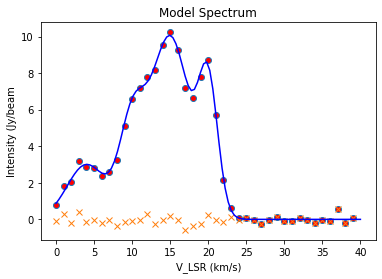

In [326]:
x_smooth = np.linspace(0, npixels, 100)
model_smooth = __model(x_smooth, g1d)
__plot(x, y, residual, x_smooth, model_smooth)

In [327]:
# params_0 are the initial guesses for the parameters, which would normally
# be provided by the user
# they are in the order [amp0, amp1, ..., ampN, center0, center1, ..., centerN,
# fwhm0, fwhm1, ..., fwhmN]
params_0 = [4.5, 2, 9, 8, 9, 5, 13, 22, 5, 7, 7, 4]
popt, perr = __fit(x, y, ngauss, params_0)

In [328]:
model_fit = __report(popt, perr, y, noise, rms_orig, chi2_orig, 3)

Solution for gaussian 0:
  Amplitude: 6.388 +/- 0.572
  Center: 10.587 +/- 0.329
  FWHM: 4.715 +/- 0.605

Solution for gaussian 1:
  Amplitude: 3.028 +/- 0.119
  Center: 3.743 +/- 0.202
  FWHM: 5.623 +/- 0.51

Solution for gaussian 2:
  Amplitude: 9.697 +/- 0.464
  Center: 15.237 +/- 0.198
  FWHM: 4.722 +/- 0.501

Solution for gaussian 3:
  Amplitude: 8.033 +/- 0.302
  Center: 19.903 +/- 0.069
  FWHM: 3.057 +/- 0.121

rms of residuals of fit: 0.158
Fit residuals have an rms that is  74.212% of the rms of the original residuals

chi-square of fit: 25.092
Chi-square of fit is 55.075% chi-square of original


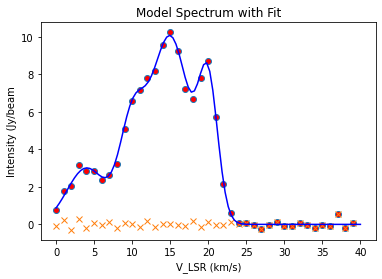

In [329]:
model_fit_smooth = __model(x_smooth, g1d)
__plot(x, y, y - model_fit, x_smooth, model_fit_smooth, True)        